### Here I plot for varying levels of dust extinction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3600) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

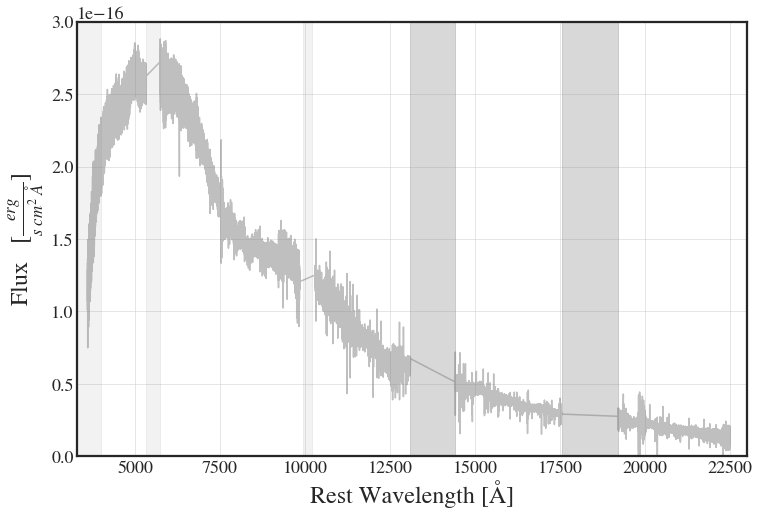

In [33]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

### Dust extinction

In [5]:
def correct_for_dust(wavelength, ra, dec):
    """Query IRSA dust map for E(B-V) value and returns reddening array
    ----------
    wavelength : numpy array-like
        Wavelength values for which to return reddening
    ra : float
        Right Ascencion in degrees
    dec : float
        Declination in degrees
    Returns
    -------
    reddening : numpy array
    Notes
    -----
    For info on the dust maps, see http://irsa.ipac.caltech.edu/applications/DUST/
    """

    from astroquery.irsa_dust import IrsaDust
    import astropy.coordinates as coord
    import astropy.units as u
    C = coord.SkyCoord(ra*u.deg, dec*u.deg, frame='fk5')

    dust_table = IrsaDust.get_query_table(C, section='ebv', timeout=60)
    ebv = dust_table["ext SandF ref"][0]

    from dust_extinction.parameter_averages import F04
    # initialize the model
    ext = F04(Rv=3.1)
    reddening = 1/ext.extinguish(wavelength*u.angstrom, Ebv=ebv)
    return  reddening

z = 0.009783 # From Hjorth et al. 2017
ra = 197.449524
dec = -23.38097

from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u
C = coord.SkyCoord(ra*u.deg, dec*u.deg, frame='fk5')

dust_table = IrsaDust.get_query_table(C, section='ebv', timeout=60)
ebv = dust_table["ext SandF ref"][0]

ebv

<ipython-input-5-406c74dfaf03>:36: DeprecationWarning: the ``irsa_dust`` module has been moved to astroquery.ipac.irsa.irsa_dust, please update your imports.
  from astroquery.irsa_dust import IrsaDust


0.1056

In [35]:
10**(0.4*0.33)

1.355189412351036

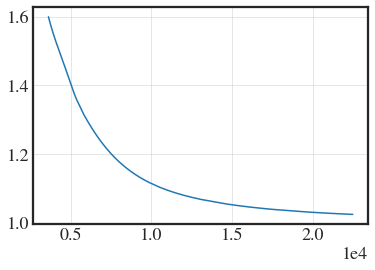

In [23]:
corr = correct_for_dust(wl, ra, dec)
plt.plot(wl, corr)

((4000.0, 22500.0), None)

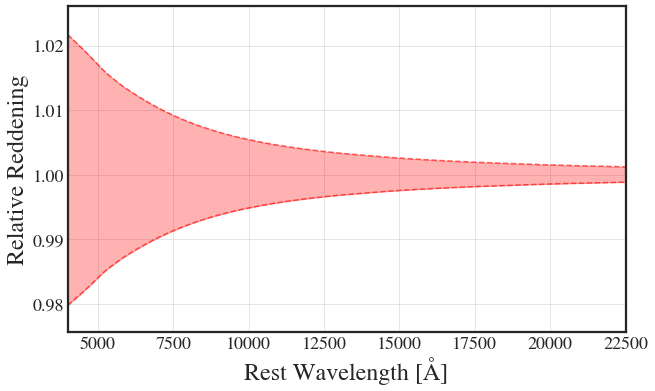

In [29]:
plt.figure(figsize=(10,6))
#plt.plot(wl, corr)

from dust_extinction.parameter_averages import F04
    # initialize the model
ext = F04(Rv=3.1)
reddening = 1/ext.extinguish(wl*u.angstrom, Ebv=ebv*1.05)
reddening2 = 1/ext.extinguish(wl*u.angstrom, Ebv=ebv/1.05)
plt.fill_between(wl, reddening/corr, reddening2/corr, alpha=0.3, color='red')
plt.plot(wl, reddening/corr, ls='--' , alpha=0.6, color='red'); 
plt.plot(wl, reddening2/corr, ls='--', alpha=0.6, color='red'); 

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Relative Reddening'), 
plt.xlim(4000,  22500), plt.ticklabel_format(axis='x', style='plain')